## Super resolution

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

from pathlib import Path

In [2]:
path = Path('/home/dl/data/CAN/v1/')
path_noisy = path/'noisy' #h
path_clean = path/'clean' #l

In [3]:
il = ImageItemList.from_folder(path_noisy)

In [4]:
bs,size=32,128
arch = models.resnet34
src = ImageImageList.from_folder(path_noisy).random_split_by_pct(0.1, seed=42)

In [5]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_clean/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
data = get_data(bs,size)

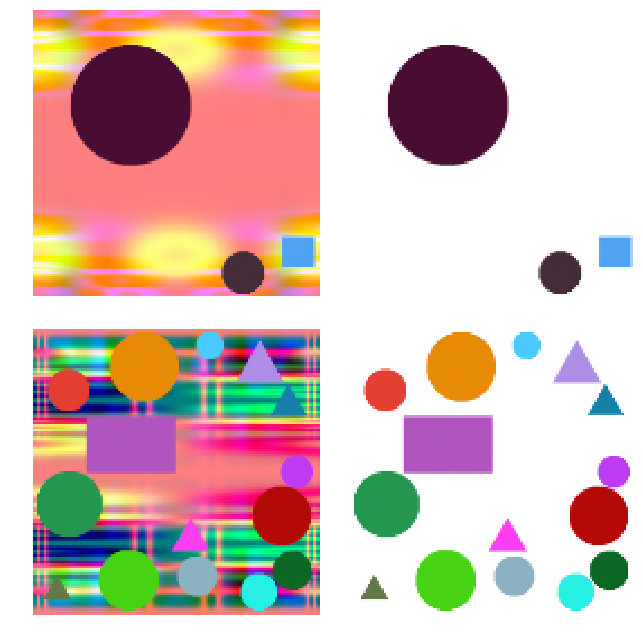

In [7]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [8]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [9]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [10]:
gram_matrix(t)

tensor([[[0.2816, 0.2787, 0.2812],
         [0.2787, 0.2788, 0.2801],
         [0.2812, 0.2801, 0.2827]],

        [[0.2816, 0.2787, 0.2812],
         [0.2787, 0.2788, 0.2801],
         [0.2812, 0.2801, 0.2827]]])

In [11]:
#l1_loss - Jeremy's preference
base_loss = F.mse_loss

In [12]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [13]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [14]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [15]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [16]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();
# learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr = 0.0005

In [20]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=10, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.461584,0.451945,0.180477,0.077282,0.147276,0.046652,0.000039,0.000209,0.000009
2,0.221560,0.210510,0.087186,0.036879,0.061699,0.024672,0.000015,0.000055,0.000004
3,0.134825,0.116426,0.050712,0.019258,0.033972,0.012432,0.000007,0.000043,0.000002
4,0.104283,0.131554,0.048596,0.017892,0.052710,0.012223,0.000008,0.000124,0.000002
5,0.072035,0.060936,0.030748,0.008882,0.015764,0.005520,0.000002,0.000019,0.000001
6,0.079624,0.047671,0.022372,0.007577,0.013338,0.004371,0.000001,0.000011,0.000001
7,0.054116,0.030023,0.014837,0.004904,0.007389,0.002889,0.000001,0.000004,0.000000
8,0.053848,0.037025,0.016726,0.005810,0.010778,0.003693,0.000001,0.000016,0.000001
9,0.045841,0.025036,0.013018,0.003881,0.006027,0.002106,0.000000,0.000004,0.000000
10,0.027421,0.016538,0.007489,0.002942,0.004506,0.001598,0.000000,0.000003,0.000000


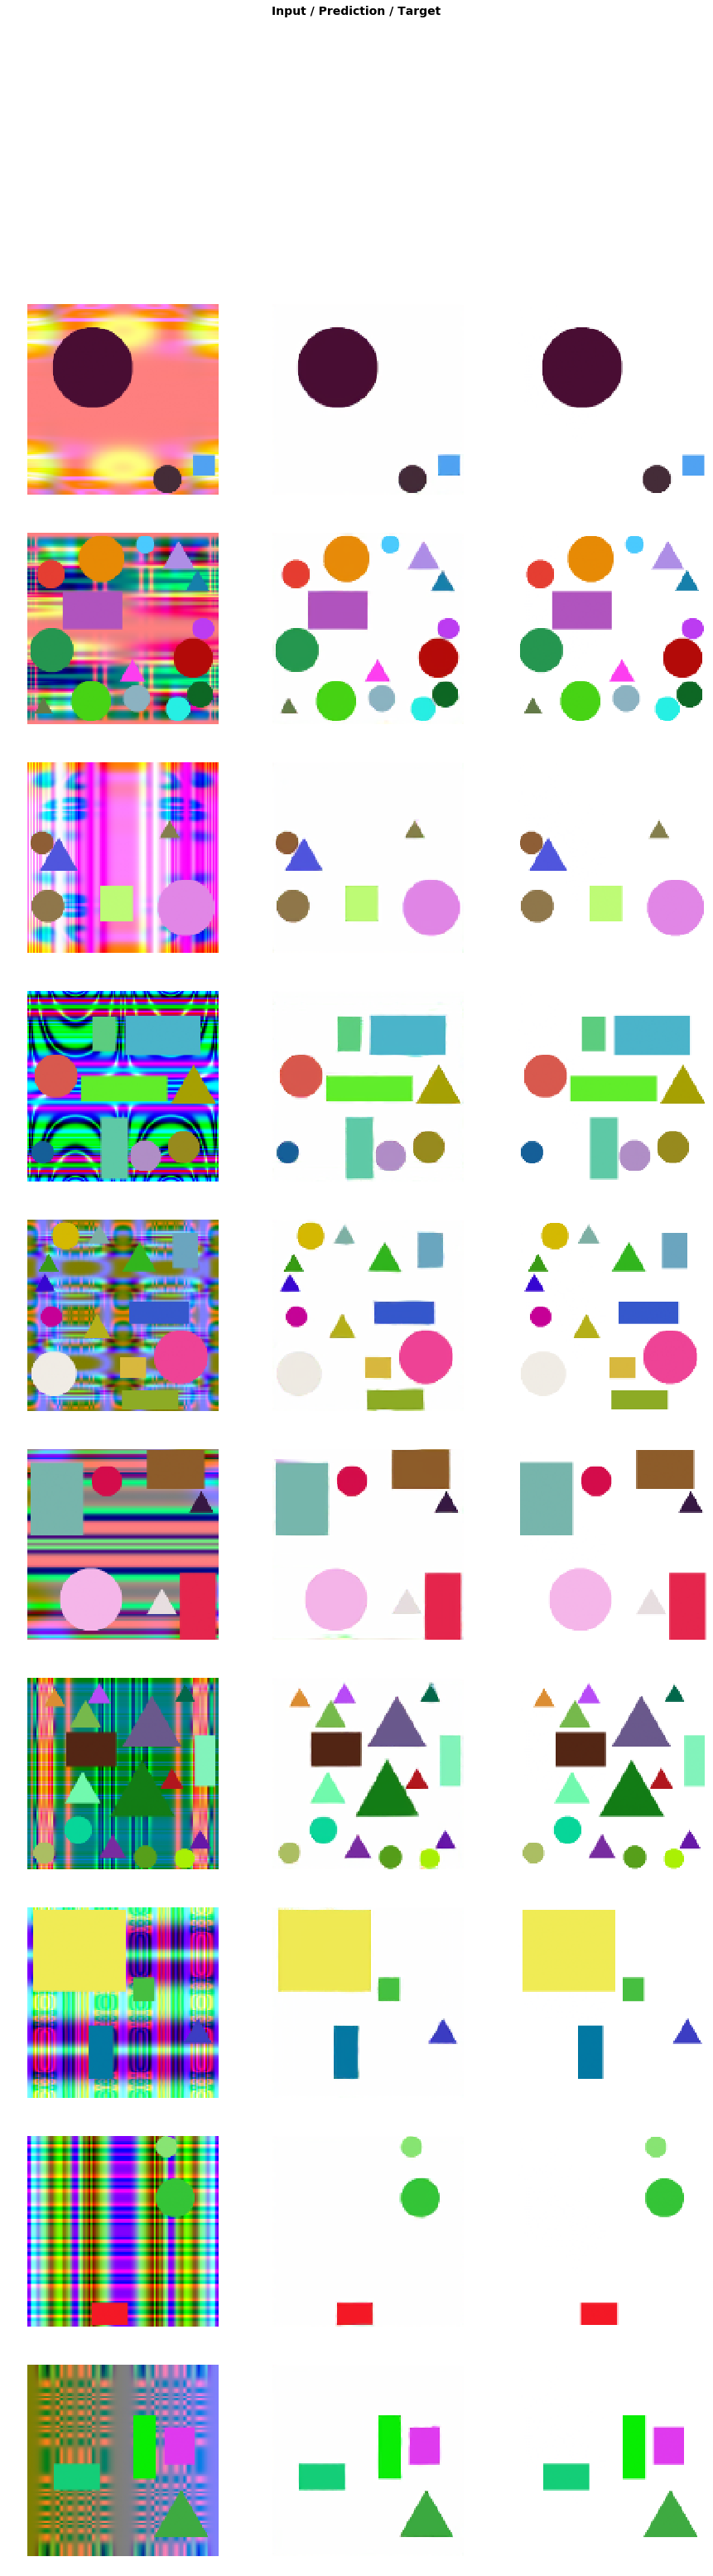

In [21]:
do_fit('1a', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.026487,0.016750,0.007515,0.002979,0.004627,0.001626,0.000000,0.000003,0.000000
2,0.024816,0.016850,0.007534,0.002994,0.004683,0.001635,0.000000,0.000003,0.000000
3,0.024785,0.016840,0.007507,0.002995,0.004700,0.001635,0.000000,0.000003,0.000000
4,0.024949,0.016505,0.007370,0.002954,0.004564,0.001614,0.000000,0.000003,0.000000
5,0.024482,0.016543,0.007274,0.002983,0.004660,0.001623,0.000000,0.000003,0.000000
6,0.024447,0.015711,0.006999,0.002847,0.004327,0.001536,0.000000,0.000002,0.000000
7,0.024085,0.016190,0.007120,0.002934,0.004545,0.001587,0.000000,0.000003,0.000000
8,0.023052,0.015611,0.006837,0.002831,0.004418,0.001522,0.000000,0.000002,0.000000
9,0.022521,0.015937,0.006931,0.002876,0.004571,0.001555,0.000000,0.000003,0.000000
10,0.023129,0.015456,0.006845,0.002812,0.004276,0.001520,0.000000,0.000002,0.000000


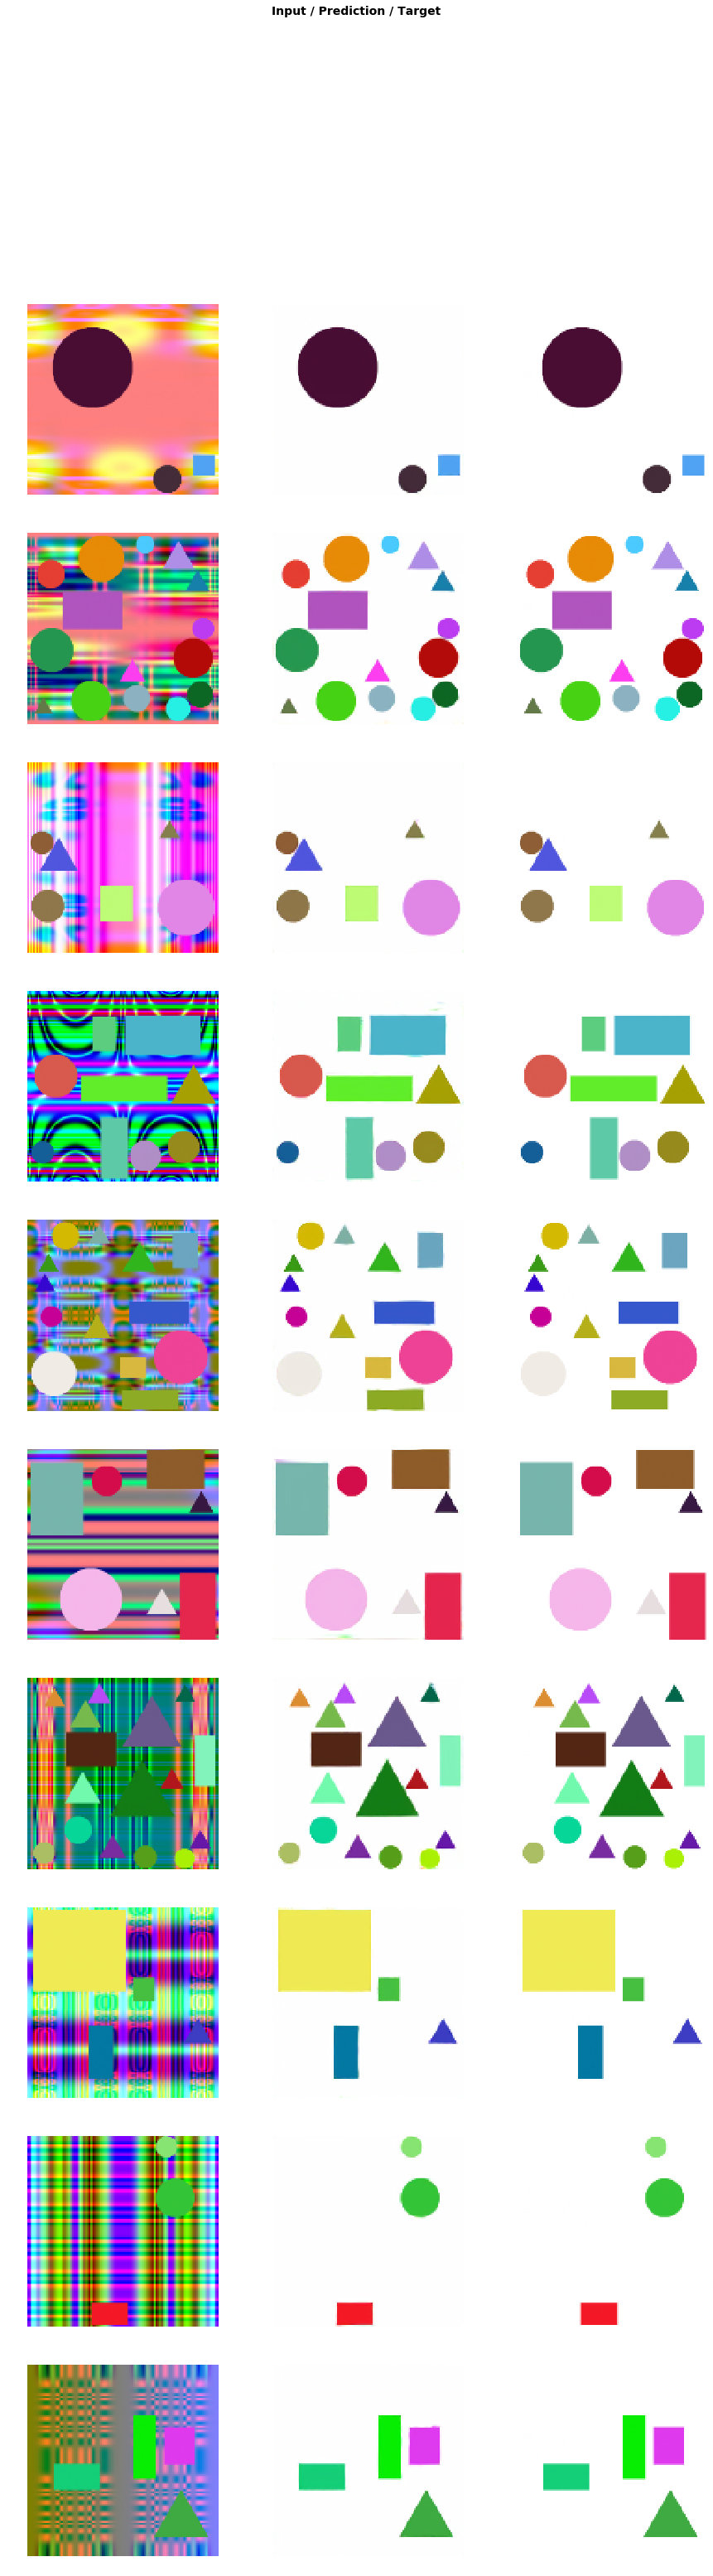

In [22]:
do_fit('1b', slice(1e-4))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.022783,0.015395,0.006883,0.002807,0.004184,0.001519,0.000000,0.000002,0.000000
2,0.022732,0.015395,0.006879,0.002801,0.004199,0.001513,0.000000,0.000002,0.000000
3,0.022703,0.015387,0.006830,0.002805,0.004231,0.001517,0.000000,0.000002,0.000000
4,0.023527,0.015823,0.006931,0.002861,0.004480,0.001548,0.000000,0.000003,0.000000
5,0.021308,0.015376,0.006783,0.002811,0.004262,0.001517,0.000000,0.000002,0.000000
6,0.023860,0.015440,0.006757,0.002806,0.004357,0.001517,0.000000,0.000003,0.000000
7,0.022179,0.015386,0.006727,0.002813,0.004328,0.001515,0.000000,0.000002,0.000000
8,0.022790,0.015093,0.006631,0.002759,0.004210,0.001490,0.000000,0.000002,0.000000
9,0.022199,0.015223,0.006625,0.002784,0.004304,0.001506,0.000000,0.000002,0.000000
10,0.021981,0.015019,0.006559,0.002744,0.004234,0.001479,0.000000,0.000003,0.000000


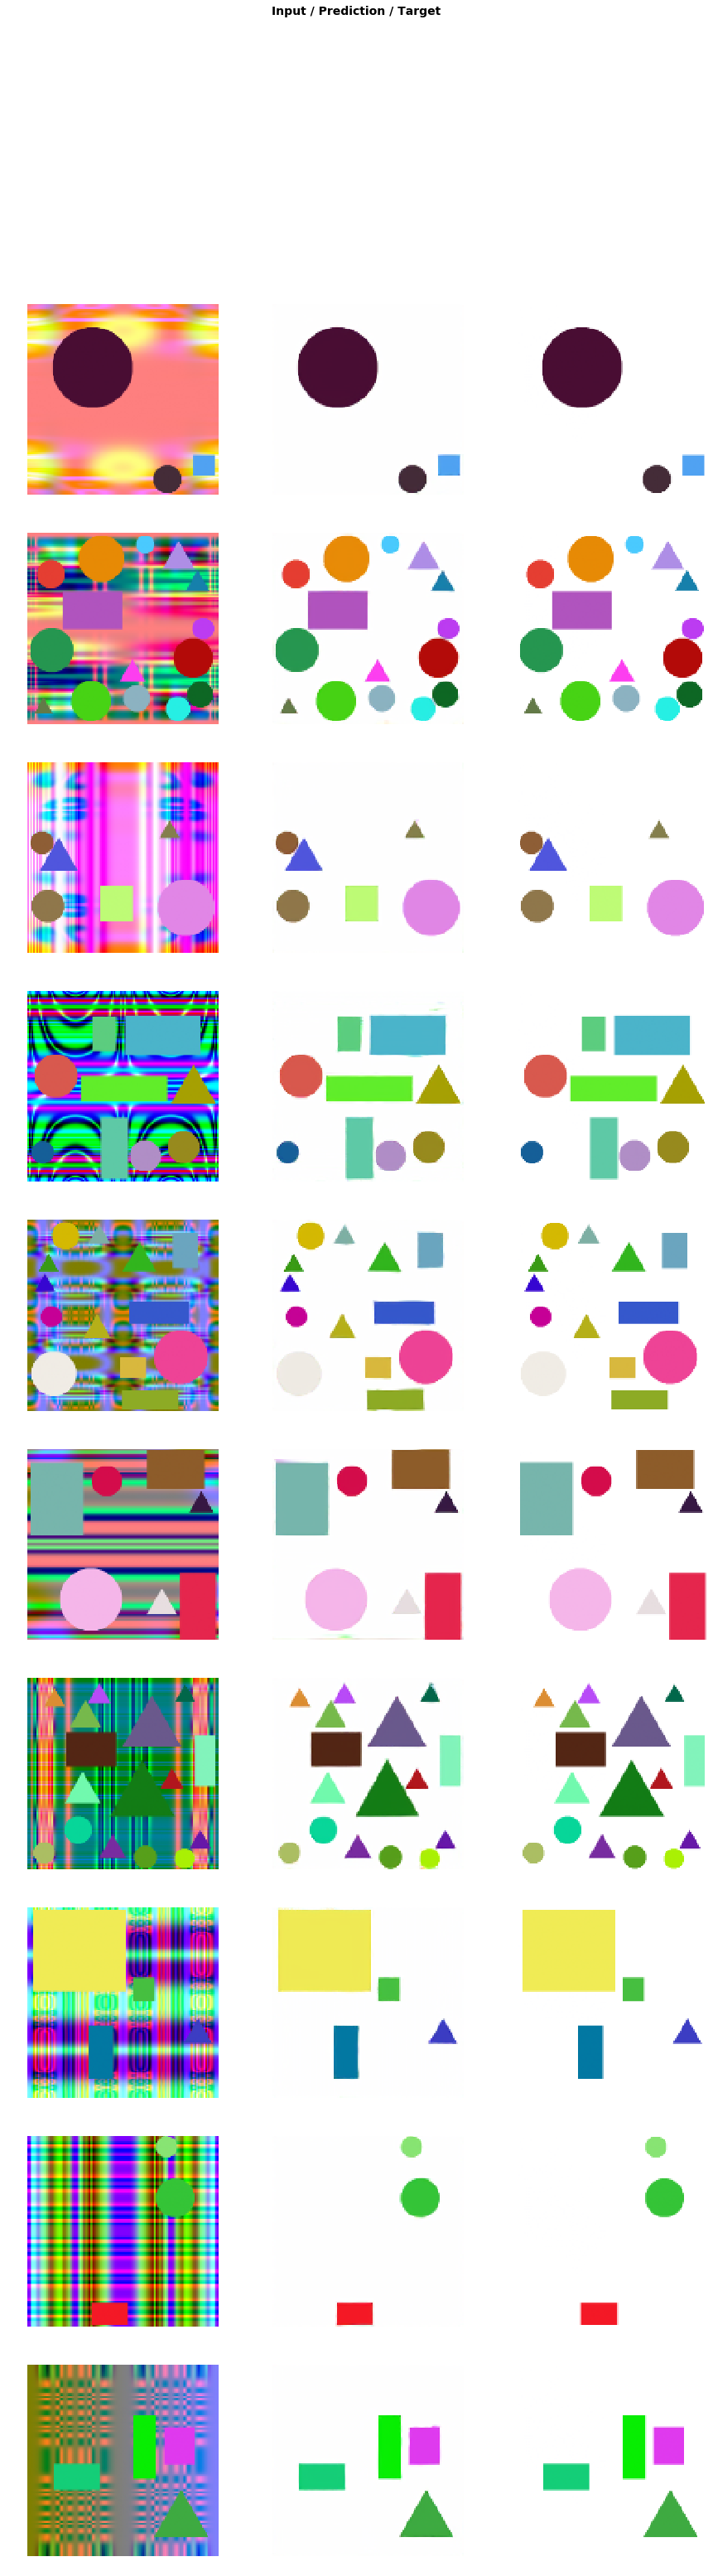

In [23]:
do_fit('1c', slice(1e-5))

In [24]:
data = get_data(bs//2,size*2)
learn.data = data
learn.freeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.033848,0.007975,0.003953,0.001093,0.001971,0.000957,0.000000,0.000001,0.000000
2,0.018518,0.006363,0.002653,0.001012,0.001811,0.000886,0.000000,0.000001,0.000000
3,0.014222,0.005717,0.002283,0.000971,0.001605,0.000859,0.000000,0.000000,0.000000
4,0.010724,0.005343,0.002179,0.000899,0.001472,0.000793,0.000000,0.000000,0.000000
5,0.014376,0.005343,0.002216,0.000889,0.001466,0.000771,0.000000,0.000000,0.000000
6,0.010661,0.004939,0.002047,0.000831,0.001339,0.000722,0.000000,0.000000,0.000000
7,0.008565,0.004651,0.001887,0.000786,0.001290,0.000688,0.000000,0.000000,0.000000
8,0.009614,0.004487,0.001955,0.000746,0.001158,0.000628,0.000000,0.000000,0.000000
9,0.007690,0.004268,0.001737,0.000737,0.001159,0.000634,0.000000,0.000000,0.000000
10,0.008153,0.003909,0.001577,0.000666,0.001096,0.000570,0.000000,0.000000,0.000000


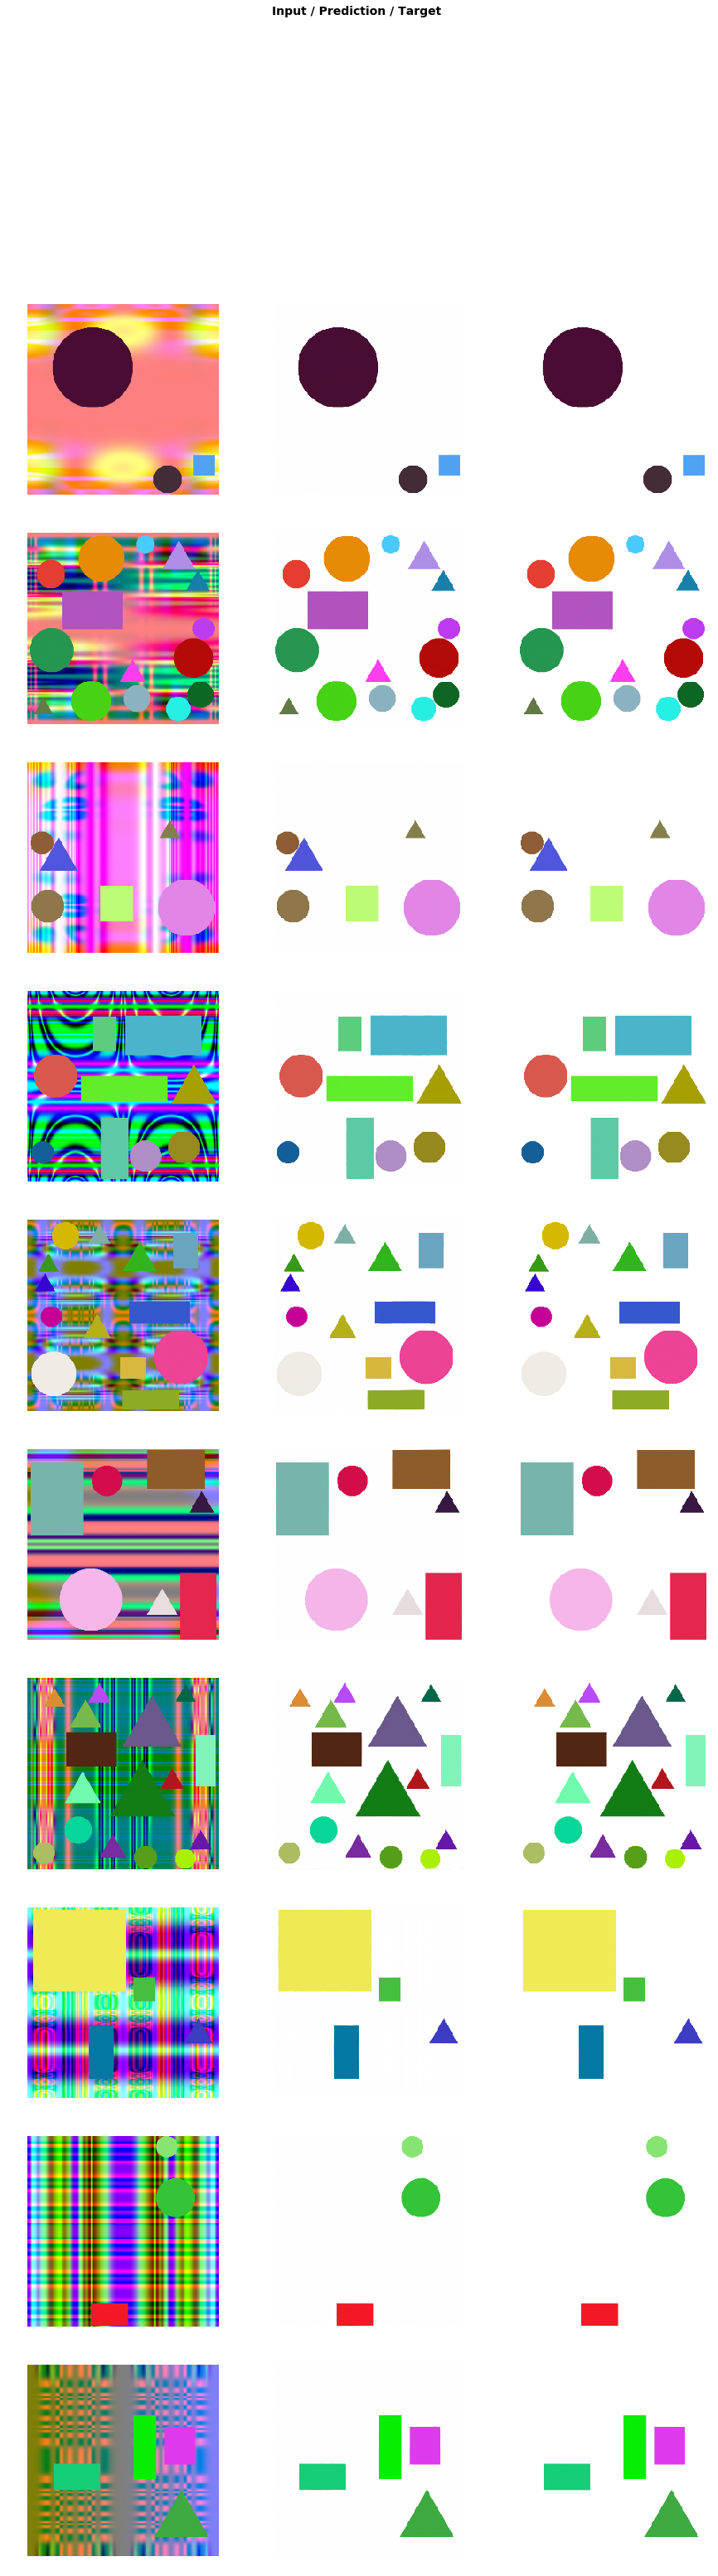

In [25]:
do_fit('2a')

## Test

In [17]:
learn.load('2a')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (9000 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/dl/data/CAN/v1/noisy
x: ImageImageList (9000 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/dl/data/CAN/v1/noisy;

Valid: LabelList
y: ImageItemList (1000 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/dl/data/CAN/v1/noisy
x: ImageImageList (1000 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /home/dl/data/CAN/v1/noisy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [18]:
data_test = (ImageImageList.from_folder(path_noisy).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_clean/x.name)
          .transform(get_transforms(), size=(256,256), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [19]:
learn.data = data_test

In [25]:
fn = data_test.valid_ds.x.items[1]; fn

PosixPath('/home/dl/data/CAN/v1/noisy/c6921054.png')

In [40]:
import glob

In [76]:
file = glob.glob('test/*.jpg')[0]

In [77]:
img = open_image(file); img.shape

torch.Size([3, 512, 512])

In [78]:
_,img_hr,b = learn.predict(img)

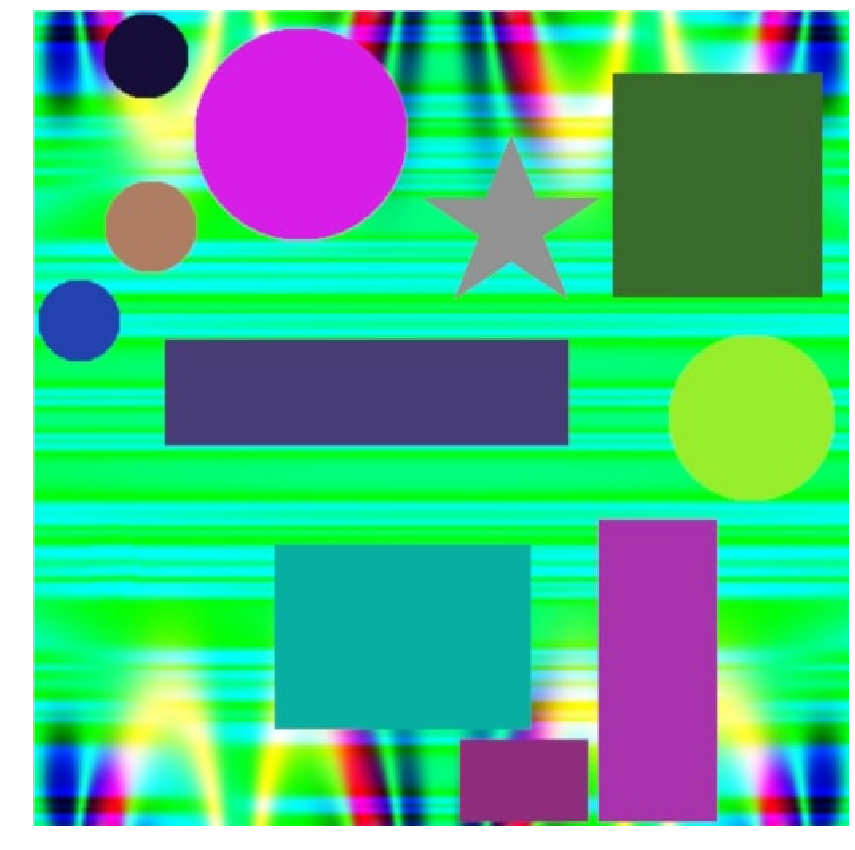

In [79]:
show_image(img, figsize=(18,15), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


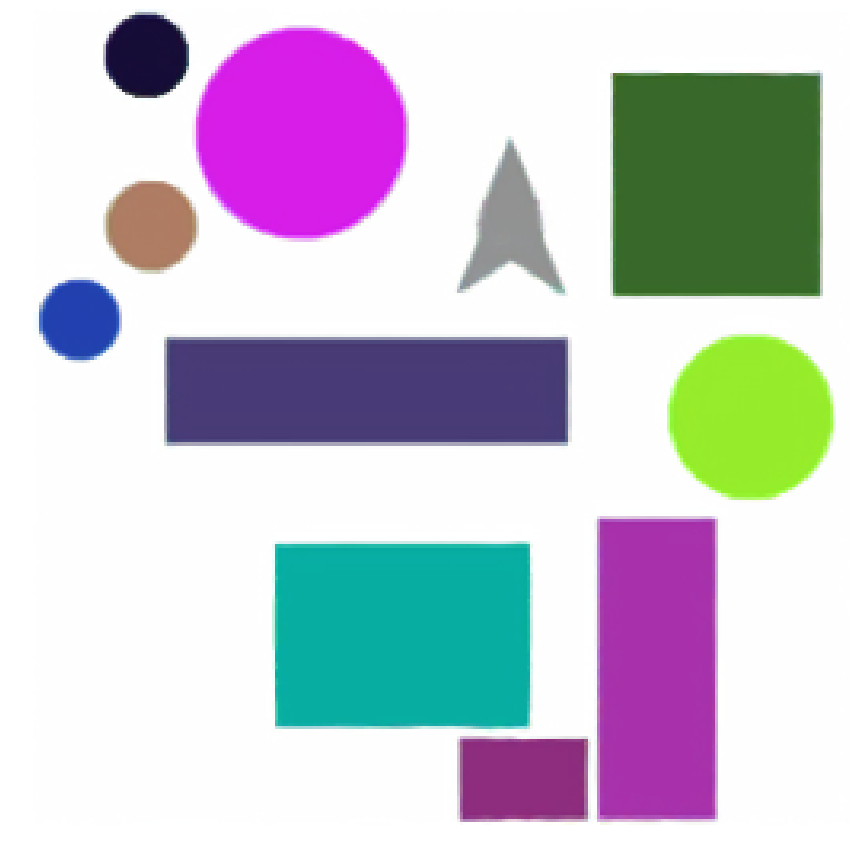

In [80]:
Image(img_hr).show(figsize=(18,15))